<a href="https://colab.research.google.com/github/ReidelVichot/LC_identification/blob/main/annual_AQI_012125.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setting the Environment

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# -- Setting environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# -- Load county shapefiles
dir = "/content/drive/MyDrive/Disertation/countyshp/"
county = gpd.read_file(dir + "tl_2010_us_county00/tl_2010_us_county00.shp")
county = county[["CNTYIDFP00", "geometry"]]

Mounted at /content/drive


In [3]:
dir = "/content/drive/MyDrive/Disertation/EPA_data/annual_AQI/"

# -- Create aqi dataframe
aqi_temp = pd.DataFrame()
# -- Columns of interest
cols = ["State", "County", "Year", "Median AQI"]

for year in range(1998, 2023):
  df = pd.read_csv(dir + f"annual_aqi_by_county_{year}.csv")
  df = df[cols]
  aqi_temp = pd.concat([aqi_temp, df]).reset_index().drop(columns="index")

##AQI

In [5]:
state_postal = "https://www2.census.gov/geo/docs/reference/state.txt"
name_to_fips = "https://www2.census.gov/geo/docs/reference/codes/files/national_county.txt"

In [6]:
states = pd.read_csv(state_postal, sep="|")
states = states.drop(columns=["STATENS"])
states.columns = ["State_fips", "State_code", "State"]

counties = pd.read_csv(name_to_fips,
                       names=["State_code","State_fips","County_fips","County","H"])
counties = counties.drop(columns=["H"])



In [10]:
temp = states.merge(counties, on=("State_code", "State_fips"))
temp["GEOID"] = temp.State_fips.astype(str).str.zfill(2) + temp.County_fips.astype(str).str.zfill(3)
temp["GEOID"] = temp.GEOID.astype(str)

temp["County"] = temp.County.str.split(" ").str[:-1].str.join(" ")

In [11]:
aqi = aqi_temp.merge(temp[["State", "County", "GEOID"]], on=("State", "County"), how="left")

In [12]:
aqi.dtypes

,0
State,object
County,object
Year,int64
Median AQI,int64
GEOID,object


In [13]:
# Removing Non-contiguous counties
for i in ['02', '15', '60', '66', '69', '72', '78', "80"]:
  aqi = aqi[aqi.GEOID.str[:2] != i]


In [14]:
# Treatmen Counties
treatments = ["18063","37179","34003","25027","13151","48329","27003","48135","42071","51107","42077","06065","34007"]

06065 18063 25027 27003 34003 34007 42071 42077 51107 13151 37179 48135 

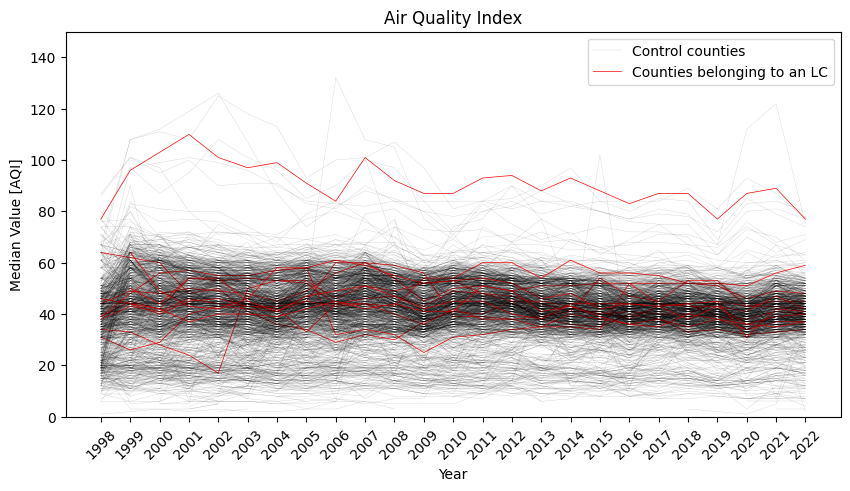

In [23]:
# Plotting trends
fig, ax = plt.subplots(figsize=(10,5))

flag0 = False
flag1 = False

for i in aqi.GEOID.unique():
  if i in treatments:
    print(i, end=" ")
    df = aqi[aqi.GEOID == i]
    if flag0 == False:
      ax.plot(df.Year, df["Median AQI"], color="red", alpha=1, linewidth=0.5, label="Counties belonging to an LC")
      flag0 = True
    else: ax.plot(df.Year, df["Median AQI"], color="red", alpha=1, linewidth=0.5)
  else:
    if flag1 == False:
      df = aqi[aqi.GEOID == i]
      ax.plot(df.Year, df["Median AQI"], color="black", alpha=0.2, linewidth=0.25, label="Control counties")
      flag1 = True
    else:
      df = aqi[aqi.GEOID == i]
      ax.plot(df.Year, df["Median AQI"], color="black", alpha=0.2, linewidth=0.25)

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Median Value [AQI]")
ax.set_ylim(0,150)
ax.legend()
ax.set_title("Air Quality Index")

fig.show()


Caption: Air Quality Index (AQI) by County. Red lines represent counties that fulfill the treatment criteria, and gray lines represent counties that conform the donor pool to construct a synthetic control.

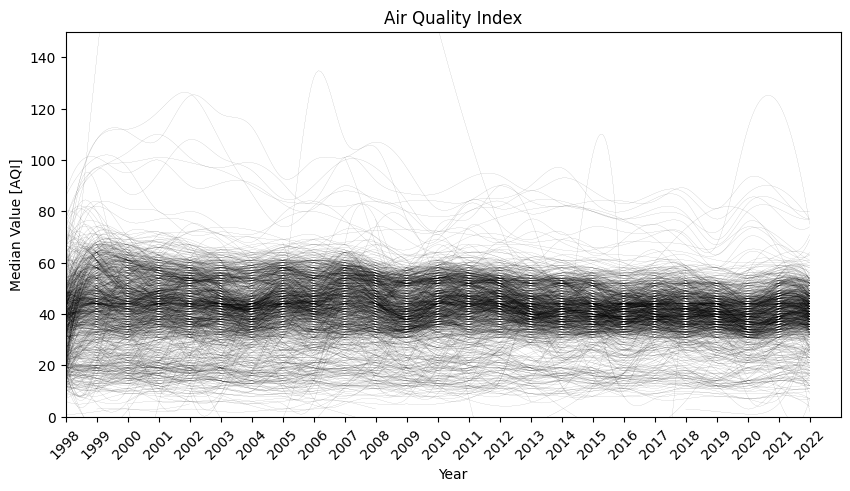

In [49]:
# Plotting trends
from scipy.interpolate import make_interp_spline, BSpline

fig, ax = plt.subplots(figsize=(10,5))

for i in aqi.GEOID.unique():
  df = aqi[aqi.GEOID == i]
  import numpy as np
  # Sample data
  x = np.array(df.Year)
  y = np.array(df["Median AQI"])

  # Check if enough data points are available for cubic spline interpolation
  if len(x) >= 4:
    # Create a smoother curve using interpolation
    x_smooth = np.linspace(x.min(), x.max(), 300)
    spl = make_interp_spline(x, y, k=3)  # k=3 for cubic spline
    y_smooth = spl(x_smooth)

    # Plot the original data and the smooth curve
    ax.plot(x_smooth, y_smooth, linewidth=0.05, color="k")
  else:
    pass

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Median Value [AQI]")
ax.set_ylim(0,150)
ax.set_xlim(1998,2023)
ax.set_title("Air Quality Index")

fig.show()

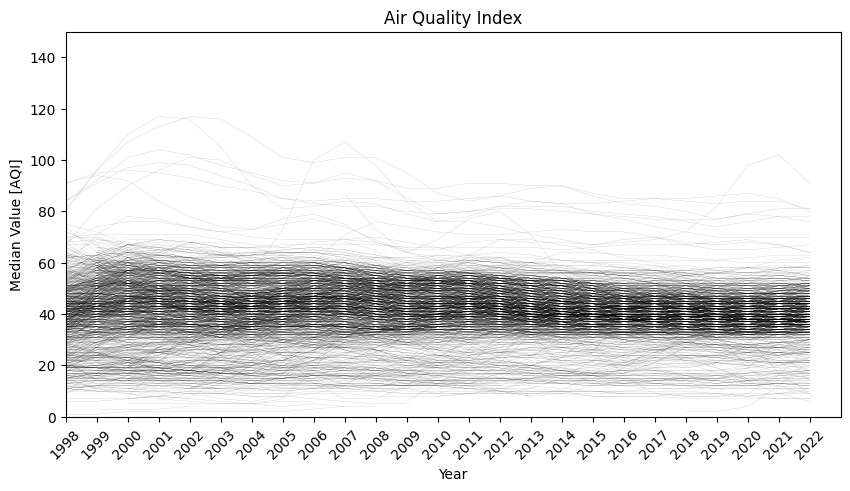

In [54]:
# Plotting trends
from scipy.ndimage import gaussian_filter1d

fig, ax = plt.subplots(figsize=(10,5))

for i in aqi.GEOID.unique():
  df = aqi[aqi.GEOID == i]
  import numpy as np
  # Sample data
  x = np.array(df.Year)
  y = np.array(df["Median AQI"])

  # Check if enough data points are available for cubic spline interpolation
  if len(x) >= 4:
    # Apply Gaussian smoothing
    y_smooth = gaussian_filter1d(y, sigma=1)  # Adjust sigma for smoothness

    # Plot the original data and the smooth curve
    # Instead of using x_smooth, use the original x values for plotting
    ax.plot(x, y_smooth, linewidth=0.05, color="k")
  else:
    pass

ax.set_xlabel("Year")
ax.tick_params(axis='x', labelrotation=45)
ax.set_xticks(range(1998, 2023))
ax.set_ylabel("Median Value [AQI]")
ax.set_ylim(0,150)
ax.set_xlim(1998,2023)
ax.set_title("Air Quality Index")

fig.show()